In [131]:
## Pawel Maczuga and Maciej Paszynski 2023

import meshio
import numpy as np
import torch

from datetime import datetime
from torch import nn
from typing import Callable, Tuple
from utils import get_initial_points, plot_intial_condition, plot_simulation_by_frame, create_gif, ReportContext, create_report, plot_running_average

In [132]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [133]:
RUN_NUM = 100

### Parameters

In [153]:
LENGTH = 2. # Domain size in x axis. Always starts at 0
TOTAL_TIME = .5 # Domain size in t axis. Always starts at 0
N_POINTS = 30 # Number of in single asxis
N_POINTS_PLOT = 300 # Number of points in single axis used in plotting

WEIGHT_RESIDUAL = 0.01 # Weight of residual part of loss function
WEIGHT_INITIAL = 2.5 # Weight of initial part of loss function
WEIGHT_BOUNDARY = 0.0005 # Weight of boundary part of loss function

# Original
# WEIGHT_RESIDUAL = 0.03 # Weight of residual part of loss function
# WEIGHT_INITIAL = 1.0 # Weight of initial part of loss function
# WEIGHT_BOUNDARY = 0.0005 # Weight of boundary part of loss function

LAYERS = 12
NEURONS_PER_LAYER = 120
EPOCHS = 10000
LEARNING_RATE = 0.00015
GRAVITY = 9.81

### Bedside

In [154]:
def floor(x, y):
    """Get the sea floor value"""
    x_raw, y_raw, z_raw = dump_points(MESH_FILENAME)
    t_raw = torch.linspace(t_domain[0], t_domain[1], steps=N_POINTS)
    z_grid, _      = torch.meshgrid(z_raw, t_raw, indexing="ij")

    return 2 #z_grid[x,y]

## PINN

In [155]:
class PINN(nn.Module):
    """Simple neural network accepting two features as input and returning a single output

    In the context of PINNs, the neural network is used as universal function approximator
    to approximate the solution of the differential equation
    """
    def __init__(self, num_hidden: int, dim_hidden: int, act=nn.Tanh()):

        super().__init__()

        self.layer_in = nn.Linear(3, dim_hidden)
        self.layer_out = nn.Linear(dim_hidden, 1)

        num_middle = num_hidden - 1
        self.middle_layers = nn.ModuleList(
            [nn.Linear(dim_hidden, dim_hidden) for _ in range(num_middle)]
        )
        self.act = act

    def forward(self, x, y, t):
        x_stack = torch.cat([x, y, t], dim=1)
        out = self.act(self.layer_in(x_stack))
        for layer in self.middle_layers:
            out = self.act(layer(out))
        logits = self.layer_out(out)
        return logits

    def device(self):
        return next(self.parameters()).device


def f(pinn: PINN, x: torch.Tensor, y: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
    """Compute the value of the approximate solution from the NN model"""
    return pinn(x, y, t)


def df(output: torch.Tensor, input: torch.Tensor, order: int = 1) -> torch.Tensor:
    """Compute neural network derivative with respect to input features using PyTorch autograd engine"""
    df_value = output
    for _ in range(order):
        df_value = torch.autograd.grad(
            df_value,
            input,
            grad_outputs=torch.ones_like(input),
            create_graph=True,
            retain_graph=True,
        )[0]

    return df_value


def dfdt(pinn: PINN, x: torch.Tensor, y: torch.Tensor, t: torch.Tensor, f_val=None, order: int = 1):
    f_value = f_val if f_val is not None else f(pinn, x, y, t)
    # f_value = f(pinn, x, y, t)
    return df(f_value, t, order=order)


def dfdx(pinn: PINN, x: torch.Tensor, y: torch.Tensor, t: torch.Tensor, f_val=None, order: int = 1):
    # f_value = f(pinn, x, y, t)
    f_value = f_val if f_val is not None else f(pinn, x, y, t)
    return df(f_value, x, order=order)

def dfdy(pinn: PINN, x: torch.Tensor, y: torch.Tensor, t: torch.Tensor, f_val=None, order: int = 1):
    # f_value = f(pinn, x, y, t)
    f_value = f_val if f_val is not None else f(pinn, x, y, t)
    return df(f_value, y, order=order)

def dzdx(z, x: torch.Tensor, y: torch.Tensor, order: int = 1):
    z_value = z(x, y)
    return df(z_value, x, order=order)

def dzdy(z, x: torch.Tensor, y: torch.Tensor, order: int = 1):
    z_value = z(x, y)
    return df(z_value, y, order=order)

## Loss function

In [156]:
def get_boundary_points(x_domain, y_domain, t_domain, n_points, device = torch.device("cpu"), requires_grad=True):
    """
         .+------+
       .' |    .'|
      +---+--+'  |
      |   |  |   |
    y |  ,+--+---+
      |.'    | .' t
      +------+'
         x
    """
    x_linspace = torch.linspace(x_domain[0], x_domain[1], n_points)
    y_linspace = torch.linspace(y_domain[0], y_domain[1], n_points)
    t_linspace = torch.linspace(t_domain[0], t_domain[1], n_points)

    x_grid, t_grid = torch.meshgrid( x_linspace, t_linspace, indexing="ij")
    y_grid, _      = torch.meshgrid( y_linspace, t_linspace, indexing="ij")

    x_grid = x_grid.reshape(-1, 1).to(device)
    x_grid.requires_grad = requires_grad
    y_grid = y_grid.reshape(-1, 1).to(device)
    y_grid.requires_grad = requires_grad
    t_grid = t_grid.reshape(-1, 1).to(device)
    t_grid.requires_grad = requires_grad

    x0 = torch.full_like(t_grid, x_domain[0], requires_grad=requires_grad)
    x1 = torch.full_like(t_grid, x_domain[1], requires_grad=requires_grad)
    y0 = torch.full_like(t_grid, y_domain[0], requires_grad=requires_grad)
    y1 = torch.full_like(t_grid, y_domain[1], requires_grad=requires_grad)

    down    = (x_grid, y0,     t_grid)
    up      = (x_grid, y1,     t_grid)
    left    = (x0,     y_grid, t_grid)
    right   = (x1,     y_grid, t_grid)

    return down, up, left, right

#### Interior basic

In [157]:
def get_interior_points(x_domain, y_domain, t_domain, n_points, device = torch.device("cpu"), requires_grad=True):
    x_raw = torch.linspace(x_domain[0], x_domain[1], steps=n_points, requires_grad=requires_grad)
    y_raw = torch.linspace(y_domain[0], y_domain[1], steps=n_points, requires_grad=requires_grad)
    t_raw = torch.linspace(t_domain[0], t_domain[1], steps=n_points, requires_grad=requires_grad)
    grids = torch.meshgrid(x_raw, y_raw, t_raw, indexing="ij")

    # W tym miejscu wczytujemy punkty z pliku siatki
    # Czy moglbys napisac tutaj wczytywanie punktow z pliku siatki
    x = grids[0].reshape(-1, 1).to(device)
    y = grids[1].reshape(-1, 1).to(device)
    t = grids[2].reshape(-1, 1).to(device)
    return x, y, t

#### Interior based on bedside map

In [158]:
MESH_FILENAME = "valparaiso_square_UTM_translated_meshes/val_square_UTM_translated_0.inp"

def normalize_mesh(filename, x_domain=(0, 1), y_domain=(0, 1), z_domain=(0, 1)):
    mesh = meshio.avsucd.read(filename)
    points = torch.tensor(mesh.points, dtype=torch.float32)
    x, y, z = points.transpose(0, 1)

    # Normalize coordinates
    min_x, min_y, min_z = torch.min(x), torch.min(y), torch.min(z)
    max_x, max_y, max_z = torch.max(x), torch.max(y), torch.max(z)

    x_min, x_max = x_domain
    y_min, y_max = y_domain
    z_min, z_max = z_domain

    x = ((x - min_x) / (max_x - min_x)) * (x_max - x_min) + x_min
    y = ((y - min_y) / (max_y - min_y)) * (y_max - y_min) + y_min
    z = ((z - min_z) / (max_z - min_z)) * (z_max - z_min) + z_min

    return x,y,z


def mesh_from_tensors(x,y,z):
    normalized_points = torch.stack((x, y, z), dim=1).tolist()
    new_mesh = meshio.Mesh(points=normalized_points, cells=mesh.cells)
    return new_mesh

def get_interior_points_mesh(x_domain, y_domain, z_domain, t_domain, n_points, device = torch.device("cpu"), requires_grad=True):
    x_raw, y_raw, z_raw = normalize_mesh(MESH_FILENAME, x_domain, y_domain, z_domain)
    t_raw = torch.linspace(t_domain[0], t_domain[1], steps=n_points)
    x_grid, t_grid = torch.meshgrid(x_raw, t_raw, indexing="ij")
    y_grid, _      = torch.meshgrid(y_raw, t_raw, indexing="ij")
    z_grid, _      = torch.meshgrid(z_raw, t_raw, indexing="ij")

    x = x_grid.reshape(-1, 1).to(device)
    y = y_grid.reshape(-1, 1).to(device)
    t = z_grid.reshape(-1, 1).to(device)
    z = t_grid.reshape(-1, 1).to(device)
    x.requires_grad = True
    y.requires_grad = True
    z.requires_grad = True
    t.requires_grad = True
    return x, y, z, t

In [ ]:
class Loss:
    def __init__(
        self,
        x_domain: Tuple[float, float],
        y_domain: Tuple[float, float],
        t_domain: Tuple[float, float],
        n_points: int,
        initial_condition: Callable,
        floor: Callable,
        weight_r: float = 1.0,
        weight_b: float = 1.0,
        weight_i: float = 1.0,
        verbose: bool = False,
    ):
        self.x_domain = x_domain
        self.y_domain = y_domain
        self.t_domain = t_domain
        self.n_points = n_points
        self.initial_condition = initial_condition
        self.floor = floor
        self.weight_r = weight_r
        self.weight_b = weight_b
        self.weight_i = weight_i

    def residual_loss(self, pinn: PINN):
        x, y, z, t = get_interior_points_mesh(self.x_domain, self.y_domain, self.y_domain, self.t_domain, self.n_points, pinn.device())
        u = f(pinn, x, y, t)
        # z_fun = lambda x,y: z[x,y]
        # print(z_fun(0,1))
        
        # z = self.floor(x, y)
        # loss = dfdt(pinn, x, y, t, u, order=2) - \
        #               GRAVITY * ((dfdx(pinn, x, y, t, u) - dzdx(z_fun, x,y))*dfdx(pinn, x, y, t, u) + \
        #               (u-z) * dfdx(pinn, x, y, t, u, order=2) + \
        #               (dfdy(pinn, x, y, t, u) - dzdy(z_fun, x,y))*dfdy(pinn, x, y, t, u) + \
        #               (u-z) * dfdy(pinn, x, y, t, u, order=2))
        loss = dfdt(pinn, x, y, t, u, order=2) - \
              GRAVITY * ( dfdx(pinn, x, y, t, u) ** 2 + \
              (u-z) * dfdx(pinn, x, y, t, u, order=2) + \
              dfdy(pinn, x, y, t, u) ** 2 + \
              (u-z) * dfdy(pinn, x, y, t, u, order=2)
              )
        return loss.pow(2).mean()

    def initial_loss(self, pinn: PINN):
        x, y, t = get_initial_points(self.x_domain, self.y_domain, self.t_domain, self.n_points, pinn.device())
        pinn_init = self.initial_condition(x, y)
        loss = f(pinn, x, y, t) - pinn_init
        return loss.pow(2).mean()

    def boundary_loss(self, pinn: PINN):
        down, up, left, right = get_boundary_points(self.x_domain, self.y_domain, self.t_domain, self.n_points, pinn.device())
        x_down,  y_down,  t_down    = down
        x_up,    y_up,    t_up      = up
        x_left,  y_left,  t_left    = left
        x_right, y_right, t_right   = right

        loss_down  = dfdy( pinn, x_down,  y_down,  t_down  )
        loss_up    = dfdy( pinn, x_up,    y_up,    t_up    )
        loss_left  = dfdx( pinn, x_left,  y_left,  t_left  )
        loss_right = dfdx( pinn, x_right, y_right, t_right )

        return loss_down.pow(2).mean()  + \
            loss_up.pow(2).mean()    + \
            loss_left.pow(2).mean()  + \
            loss_right.pow(2).mean()

    def verbose(self, pinn: PINN, only_initial=False):
        """
        Returns all parts of the loss function

        Not used during training! Only for checking the results later.
        """
        residual_loss = self.residual_loss(pinn)
        initial_loss = self.initial_loss(pinn)
        boundary_loss = self.boundary_loss(pinn)

        final_loss = \
            self.weight_r * residual_loss + \
            self.weight_i * initial_loss + \
            self.weight_b * boundary_loss

        if only_initial:
          final_loss = \
            self.weight_r * residual_loss + \
            self.weight_i * initial_loss + \
            self.weight_b * boundary_loss # 5, 1000 i 1?, 0.0005

        return final_loss, residual_loss, initial_loss, boundary_loss

    def __call__(self, pinn: PINN, only_initial=False):
        """
        Allows you to use instance of this class as if it was a function:

        ```
            >>> loss = Loss(*some_args)
            >>> calculated_loss = loss(pinn)
        ```
        """
        return self.verbose(pinn, only_initial)

## Train function

In [ ]:
def train_model(
    nn_approximator: PINN,
    loss_fn: Callable,
    learning_rate: int = 0.01,
    max_epochs: int = 1_000
) -> PINN:

    optimizer = torch.optim.Adam(nn_approximator.parameters(), lr=learning_rate)
    loss_values = []
    residual_loss_values = []
    initial_loss_values = []
    boundary_loss_values = []
    top_loss = 100000000

    for epoch in range(max_epochs):
        try:
            loss: torch.Tensor = loss_fn(nn_approximator)
            optimizer.zero_grad()
            loss[0].backward()
            torch.nn.utils.clip_grad_norm_(nn_approximator.parameters(), 0.5)
            optimizer.step()

            if loss[0].item() < top_loss:
                torch.save(nn_approximator, f"./best_{RUN_NUM}.pt")
                top_loss = loss[0].item()

            loss_values.append(loss[0].item())
            residual_loss_values.append(loss[1].item())
            initial_loss_values.append(loss[2].item())
            boundary_loss_values.append(loss[3].item())
            if (epoch + 1) % 1000 == 0:
                print(f"Epoch: {epoch + 1} - Loss: {float(loss[0].item()):>7f}, Residual Loss: {float(loss[1].item()):>7f}, Initital Loss: {float(loss[2].item()):>7f}, Boundary Loss: {float(loss[3].item()):>7f}")

        except KeyboardInterrupt:
            break

    return nn_approximator, np.array(loss_values), np.array(residual_loss_values), np.array(initial_loss_values), np.array(boundary_loss_values)

In [ ]:
def floor(x, y):
    """Get the sea floor value"""
    x_raw, y_raw, z_raw = dump_points(MESH_FILENAME)
    t_raw = torch.linspace(t_domain[0], t_domain[1], steps=N_POINTS)
    z_grid, _      = torch.meshgrid(z_raw, t_raw, indexing="ij")

    return 2 #z_grid[x,y]

### Initial condition

In [ ]:
def initial_condition(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    r = torch.sqrt((x-LENGTH/2)**2 + (y-LENGTH/2)**2)
    res = 2 * torch.exp(-(r)**2 * 30) + 2
    return res

# Running code

## Train data

In [ ]:
# # with profiling
# global x_domain, y_domain, t_domain, loss_fn, pinn_trained, loss_values, residual_loss_values, initial_loss_values, boundary_loss_values, losses

# def run_training():
#     pinn = PINN(LAYERS, NEURONS_PER_LAYER, act=nn.Tanh()).to(device)
    
#     x_domain = [0.0, LENGTH]
#     y_domain = [0.0, LENGTH]
#     t_domain = [0.0, TOTAL_TIME]
    
#     # train the PINN
#     loss_fn = Loss(
#         x_domain=x_domain,
#         y_domain=y_domain,
#         t_domain=t_domain,
#         n_points=N_POINTS,
#         initial_condition=initial_condition,
#         floor=floor,
#         weight_r=WEIGHT_RESIDUAL,
#         weight_b=WEIGHT_BOUNDARY,
#         weight_i=WEIGHT_INITIAL
#     )
    
#     pinn_trained, loss_values, residual_loss_values, initial_loss_values, boundary_loss_values = train_model(
#         pinn, loss_fn=loss_fn, learning_rate=LEARNING_RATE, max_epochs=EPOCHS)
    
#     pinn = pinn.cpu()
#     losses = loss_fn.verbose(pinn)
#     print(f'Total loss: \t{losses[0]:.5f} ({losses[0]:.3E})')
#     print(f'Interior loss: \t{losses[1]:.5f} ({losses[1]:.3E})')
#     print(f'Initial loss: \t{losses[2]:.5f} ({losses[2]:.3E})')
#     print(f'Boundary loss: \t{losses[3]:.5f} ({losses[3]:.3E})')

# %prun -D program3.prof run_training()

In [ ]:
pinn = PINN(LAYERS, NEURONS_PER_LAYER, act=nn.Tanh()).to(device)

x_domain = [0.0, LENGTH]
y_domain = [0.0, LENGTH]
t_domain = [0.0, TOTAL_TIME]

# train the PINN
loss_fn = Loss(
    x_domain=x_domain,
    y_domain=y_domain,
    t_domain=t_domain,
    n_points=N_POINTS,
    initial_condition=initial_condition,
    floor=floor,
    weight_r=WEIGHT_RESIDUAL,
    weight_b=WEIGHT_BOUNDARY,
    weight_i=WEIGHT_INITIAL
)

pinn_trained, loss_values, residual_loss_values, initial_loss_values, boundary_loss_values = train_model(
    pinn, loss_fn=loss_fn, learning_rate=LEARNING_RATE, max_epochs=EPOCHS)

pinn = pinn.cpu()
losses = loss_fn.verbose(pinn)

print(f'Total loss: \t{losses[0]:.5f} ({losses[0]:.3E})')
print(f'Interior loss: \t{losses[1]:.5f} ({losses[1]:.3E})')
print(f'Initial loss: \t{losses[2]:.5f} ({losses[2]:.3E})')
print(f'Boundary loss: \t{losses[3]:.5f} ({losses[3]:.3E})')

In [ ]:
plot_running_average(loss_values, "Loss function (runnig average)", "total_loss")

In [ ]:
plot_running_average(residual_loss_values, "Residual loss function (running average)", "residual_loss")

In [ ]:
plot_running_average(initial_loss_values, "Initial loss function (running average)", "initial_loss")

In [ ]:
plot_running_average(boundary_loss_values, "Boundary loss function (running average)", "boundary_loss")

In [ ]:
plot_intial_condition(x_domain=x_domain, 
                      y_domain=y_domain, 
                      t_domain=t_domain,
                      pinn=pinn,
                      initial_condition=initial_condition,
                      n_points=N_POINTS_PLOT,
                      length=LENGTH,
                      floor=floor)

In [ ]:
plot_simulation_by_frame(total_time=TOTAL_TIME,
                   x_domain=x_domain, 
                   y_domain=y_domain, 
                   t_domain=t_domain,
                   pinn=pinn,
                   n_points=N_POINTS_PLOT,
                   length=LENGTH,
                   floor=floor)

In [ ]:
create_gif(TOTAL_TIME, title=f"tsunami_{RUN_NUM}")

In [ ]:
date = datetime.now()

context: ReportContext = {
           'num': RUN_NUM,
           'date': date,
           'WEIGHT_RESIDUAL': WEIGHT_RESIDUAL, 
           'WEIGHT_INITIAL': WEIGHT_INITIAL, 
           'WEIGHT_BOUNDARY': WEIGHT_BOUNDARY,
           'LAYERS': LAYERS, 
           'NEURONS_PER_LAYER': NEURONS_PER_LAYER,
           'EPOCHS': EPOCHS, 
           'LEARNING_RATE': LEARNING_RATE,
           'total_loss': f"{losses[0]:.3E}",
           "residual_loss": f"{losses[1]:.3E}",
           "initial_loss": f"{losses[2]:.3E}",
           "boundary_loss": f"{losses[3]:.3E}",
           "img1": "./results/total_loss.png",
           "img2": "./results/residual_loss.png",
           "img3": "./results/initial_loss.png",
           "img4": "./results/boundary_loss.png",
    }

create_report(context,
              env_path='./',
              template_path='report_template.html',
              report_title=f"report_{RUN_NUM}.pdf")

### Evaluation

In [23]:
model = torch.load(f"./best_{RUN_NUM}.pt")

In [24]:
plot_simulation_by_frame(total_time=TOTAL_TIME,
                   x_domain=x_domain, 
                   y_domain=y_domain, 
                   t_domain=t_domain,
                   pinn=model,
                   n_points=N_POINTS_PLOT,
                   length=LENGTH,
                   floor=floor)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

In [ ]:
import imageio
import jinja2
import matplotlib.pyplot as plt
import numpy as np
import torch

from datetime import datetime
from matplotlib.animation import FuncAnimation
from typing import List, TypedDict, Callable
from xhtml2pdf import pisa


class ReportContext(TypedDict):
    num: int
    date: datetime
    WEIGHT_RESIDUAL: float 
    WEIGHT_INITIAL: float 
    WEIGHT_BOUNDARY: float
    LAYERS: int
    NEURONS_PER_LAYER: int
    EPOCHS: int 
    LEARNING_RATE: float
    total_loss: float
    residual_loss: float
    initial_loss: float
    boundary_loss: float
    img1: str
    img2: str
    img3: str
    img4: str


def create_report(context: ReportContext, 
                  env_path: str, 
                  template_path: str, 
                  report_title: str) -> None:
    template_loader = jinja2.FileSystemLoader(env_path)
    template_env = jinja2.Environment(loader=template_loader)

    template = template_env.get_template(template_path)
    output_text = template.render(context)
    
    with open(f'./results/{report_title}', "w+b") as out_pdf_file_handle:
        pisa.CreatePDF(src=output_text, dest=out_pdf_file_handle)
        
def create_gif(total_time: float, 
               title: str, 
               step: float=0.01, 
               base_dir: str=".", 
               duration: float=0.1) -> None:
    time_values = np.arange(0, total_time, step)
    frames = []
    for idx in range(len(time_values)):
        image = imageio.v2.imread(base_dir + '/img/img_{:03d}.png'.format(idx))
        frames.append(image)

    imageio.mimsave(f'{base_dir}/results/{title}.gif', frames, duration=duration)

def get_initial_points(x_domain: List[float], 
                       y_domain: List[float], 
                       t_domain: List[float], 
                       n_points: int, 
                       device=torch.device("cpu"), 
                       requires_grad=True):
    x_linspace = torch.linspace(x_domain[0], x_domain[1], n_points)
    y_linspace = torch.linspace(y_domain[0], y_domain[1], n_points)
    x_grid, y_grid = torch.meshgrid( x_linspace, y_linspace, indexing="ij")
    x_grid = x_grid.reshape(-1, 1).to(device)
    x_grid.requires_grad = requires_grad
    y_grid = y_grid.reshape(-1, 1).to(device)
    y_grid.requires_grad = requires_grad
    t0 = torch.full_like(x_grid, t_domain[0], requires_grad=requires_grad)
    return (x_grid, y_grid, t0)

def plot_intial_condition(x_domain: List[float], 
                          y_domain: List[float], 
                          t_domain: List[float],
                          length: float,
                          pinn: 'PINN',
                          initial_condition: Callable,
                          floor: Callable,
                          n_points: int) -> None:
    title = "Initial condition"
    
    x, y, _ = get_initial_points(x_domain, y_domain, t_domain, n_points, requires_grad=False)
    z = initial_condition(x, y)
    
    fig = plot_color(z, x, y, n_points, n_points, f"{title} - exact")
    fig = plot_3D(z, x, y, n_points, n_points, length, floor, f"{title} - exact")
    
    t_value = 0.0
    t = torch.full_like(x, t_value)
    z = pinn(x, y, t)
    
    fig = plot_color(z, x, y, n_points, n_points, f"{title} - PINN")    
    fig = plot_3D(z, x, y, n_points, n_points, length, floor, f"{title} - PINN")
    

def plot_frame(x_domain: List[float], 
               y_domain: List[float], 
               t_domain: List[float], 
               pinn: 'PINN', 
               idx: int, 
               t_value: float, 
               n_points: int,
               length: float,
               floor: Callable,
               base_dir: str=".") -> None:
    x, y, _ = get_initial_points(x_domain, y_domain, t_domain, n_points, requires_grad=False)
    t = torch.full_like(x, t_value)
    z = pinn(x, y, t)
    fig = plot_color(z, x, y, n_points, n_points, f"PINN for t = {t_value}")
    fig = plot_3D(z, x, y, n_points, n_points, length, floor, f"PINN for t = {t_value}")
    plt.savefig(base_dir + '/img/img_{:03d}.png'.format(idx))


def plot_simulation_by_frame(total_time: float, 
                             x_domain: List[float], 
                             y_domain: List[float], 
                             t_domain: List[float], 
                             pinn: 'PINN', 
                             n_points: int,
                             length: float,
                              floor: Callable,
                             step:float=0.01) -> None:
    time_values = np.arange(0, total_time, step)

    for idx, t_value in enumerate(time_values):
        plot_frame(x_domain=x_domain, 
                   y_domain=y_domain, 
                   t_domain=t_domain,
                   pinn=pinn,
                   idx=idx,
                   t_value=t_value,
                   n_points=n_points,
                   length=length,
                   floor=floor)

def running_average(y, window: int=100):
    cumsum = np.cumsum(np.insert(y, 0, 0))
    return (cumsum[window:] - cumsum[:-window]) / float(window)

def plot_running_average(loss_values, title: str, path: str):
    average_loss = running_average(loss_values, window=100)
    fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
    ax.set_title(title)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.plot(average_loss)
    ax.set_yscale('log')
    
    fig.savefig(f'./results/{path}.png')

def plot_solution(pinn: 'PINN', x: torch.Tensor, t: torch.Tensor, figsize=(8, 6), dpi=100):

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    x_raw = torch.unique(x).reshape(-1, 1)
    t_raw = torch.unique(t)

    def animate(i):
        if not i % 10 == 0:
            t_partial = torch.ones_like(x_raw) * t_raw[i]
            f_final = f(pinn, x_raw, t_partial)
            ax.clear()
            ax.plot(
                x_raw.detach().numpy(), f_final.detach().numpy(), label=f"Time {float(t[i])}"
            )
            ax.set_ylim(-1, 1)
            ax.legend()

    n_frames = t_raw.shape[0]
    return FuncAnimation(fig, animate, frames=n_frames, interval=100, repeat=False)

def plot_color(z: torch.Tensor, x: torch.Tensor, y: torch.Tensor, n_points_x, n_points_t, title, figsize=(8, 6), dpi=100, cmap="viridis"):
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    z_raw = z.detach().cpu().numpy()
    x_raw = x.detach().cpu().numpy()
    y_raw = y.detach().cpu().numpy()
    X = x_raw.reshape(n_points_x, n_points_t)
    Y = y_raw.reshape(n_points_x, n_points_t)
    Z = z_raw.reshape(n_points_x, n_points_t)
    ax.set_title(title)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    c = ax.pcolormesh(X, Y, Z, cmap=cmap)
    fig.colorbar(c, ax=ax)

    return fig

def plot_3D(z: torch.Tensor, x: torch.Tensor, y: torch.Tensor, n_points_x, n_points_t, length: float,  z: torch.Tensor, title, figsize=(8, 6), dpi=100, limit=5):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(projection='3d')
    z_raw = z.detach().cpu().numpy()
    x_raw = x.detach().cpu().numpy()
    y_raw = y.detach().cpu().numpy()
    X = x_raw.reshape(n_points_x, n_points_t)
    Y = y_raw.reshape(n_points_x, n_points_t)
    Z = z_raw.reshape(n_points_x, n_points_t)
    ax.set_title(title)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.axes.set_zlim3d(bottom=-limit, top=limit)

    c = ax.plot_surface(X, Y, Z)

    x_floor = torch.linspace(0.0, length, 50)
    y_floor = torch.linspace(0.0, length, 50)
    z_floor = torch.zeros((50, 50))
    for x_idx, x_coord in enumerate(x_floor):
        for y_idx, y_coord in enumerate(y_floor):
            z_floor[x_idx, y_idx] = floor(x_coord, y_coord)
    x_floor = torch.tile(x_floor, (50, 1))
    y_floor = torch.tile(y_floor, (50, 1)).T
    f = ax.plot_surface(x_floor, y_floor, z_floor, color='green', alpha=0.7)

    return fig

In [ ]:
MESH_FILENAME = "valparaiso_square_UTM_translated_meshes/val_square_UTM_translated_0.inp"

def get_interior_points_mesh(x_domain, y_domain, t_domain, n_points, device = torch.device("cpu"), requires_grad=True):
    x_raw, y_raw, z_raw = dump_points(MESH_FILENAME)
    t_raw = torch.linspace(t_domain[0], t_domain[1], steps=n_points)
    x_grid, t_grid = torch.meshgrid(x_raw, t_raw, indexing="ij")
    y_grid, _      = torch.meshgrid(y_raw, t_raw, indexing="ij")
    z_grid, _      = torch.meshgrid(z_raw, t_raw, indexing="ij")

    x = x_grid.reshape(-1, 1).to(device)
    y = y_grid.reshape(-1, 1).to(device)
    t = z_grid.reshape(-1, 1).to(device)
    z = t_grid.reshape(-1, 1).to(device)
    x.requires_grad = True
    y.requires_grad = True
    z.requires_grad = True
    t.requires_grad = True
    return x, y, z, t


def dump_points(filename):
    mesh = meshio.avsucd.read(filename)
    points = torch.tensor(mesh.points, dtype=torch.float32)
    x,y,z = points.transpose(0,1)
    #-> translate into [0,1]
    min_x = min(x)
    min_y = min(y)
    max_x = max(x)
    max_y = max(y)
    min_z = min(z)
    max_z = max(z)
    x = x - min_x
    y = y - min_y
#    z = z - min_z
    dx = max_x - min_x
    dy = max_y - min_y
    dz = max_z - min_z
    x = x / dx
    y = y / dy
    z = z / dz
    #<-
    return x,y,z

def normalize_mesh(filename):
    mesh = meshio.avsucd.read(filename)
    points = torch.tensor(mesh.points, dtype=torch.float32)
    x, y, z = points.transpose(0, 1)

    # Normalize coordinates to [0, 1]
    min_x, min_y, min_z = torch.min(x), torch.min(y), torch.min(z)
    max_x, max_y, max_z = torch.max(x), torch.max(y), torch.max(z)
    x = (x - min_x) / (max_x - min_x)
    y = (y - min_y) / (max_y - min_y)
    z = (z - min_z) / (max_z - min_z)

    return x,y,z

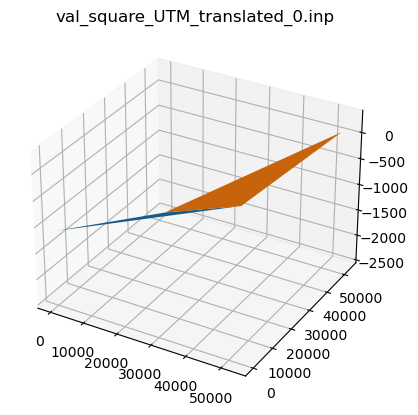

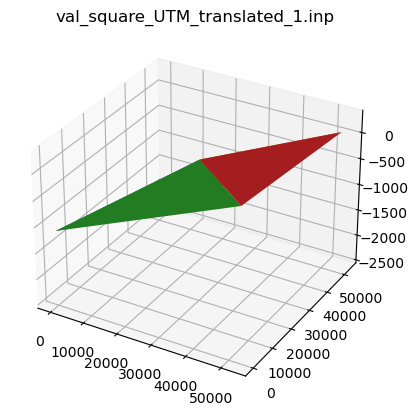

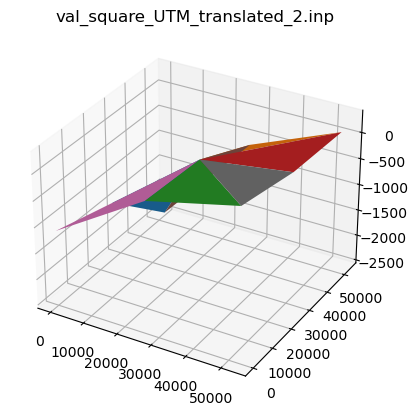

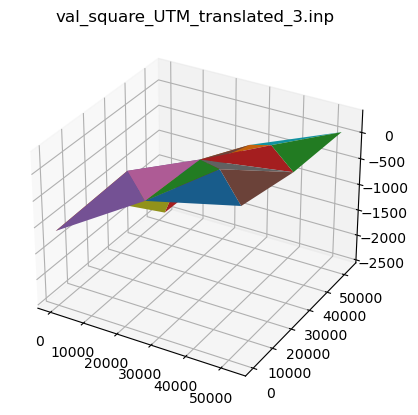

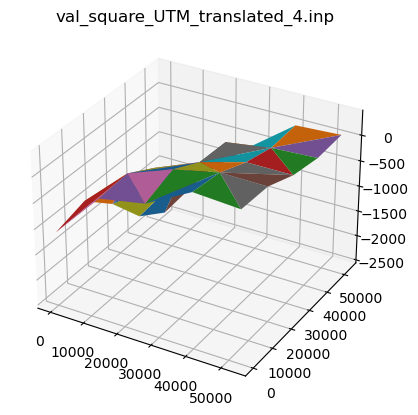

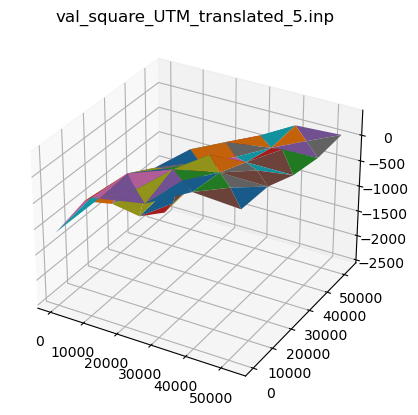

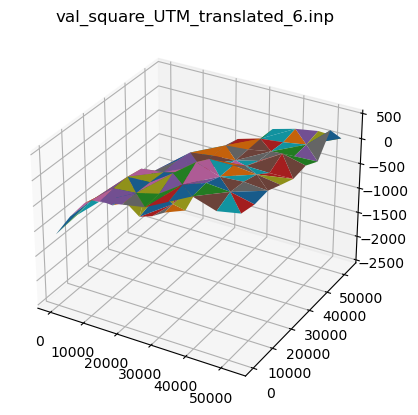

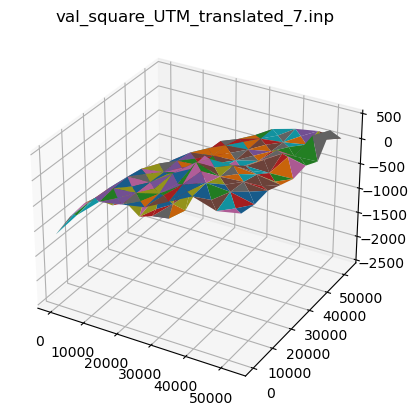

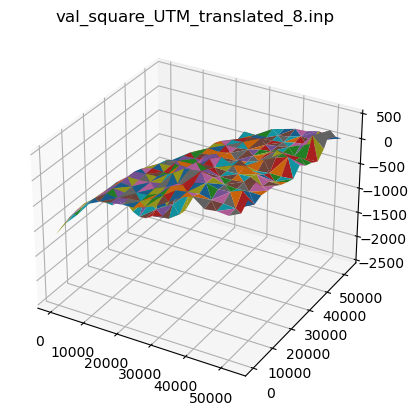

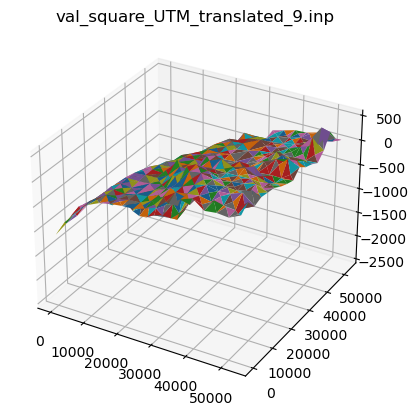

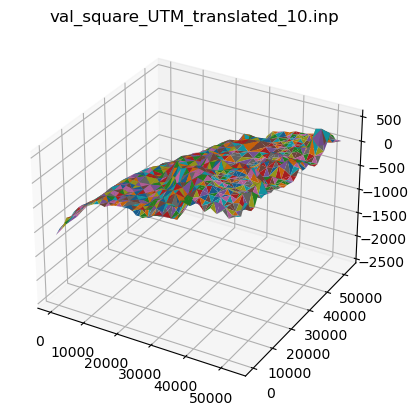

KeyboardInterrupt: 

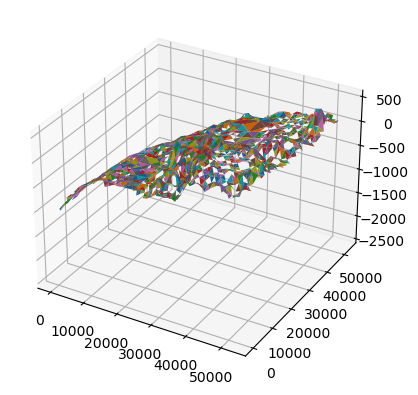

In [105]:
import meshio
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

MESH_FILENAME = "valparaiso_square_UTM_translated_meshes/val_square_UTM_translated_5.inp"

def plot_mesh(filename):
    mesh = meshio.avsucd.read(filename)    
    points = mesh.points
    cells = mesh.cells

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    for cell in cells:
        if cell.type == "triangle":
            cell_data = cell.data
            for triangle in cell_data:

                vertices = points[triangle]
                x, y, z = vertices[:, 0], vertices[:, 1], vertices[:, 2]
                ax.plot_trisurf(x, y, z, linewidth=0.2)
    plt.title(filename.split("/")[-1])

    plt.show()


for i in range(0,16):
    filename = f"valparaiso_square_UTM_translated_meshes/val_square_UTM_translated_{i}.inp"
    plot_mesh(filename)

In [119]:
MESH_FILENAME = "valparaiso_square_UTM_translated_meshes/val_square_UTM_translated_1.inp"

In [169]:
mesh = meshio.avsucd.read(MESH_FILENAME)

def normalize_mesh(filename, x_domain=(0, 1), y_domain=(0, 1), z_domain=(0, 1)):
    mesh = meshio.avsucd.read(filename)
    points = torch.tensor(mesh.points, dtype=torch.float32)
    x, y, z = points.transpose(0, 1)

    # Normalize coordinates
    min_x, min_y, min_z = torch.min(x), torch.min(y), torch.min(z)
    max_x, max_y, max_z = torch.max(x), torch.max(y), torch.max(z)

    x_min, x_max = x_domain
    y_min, y_max = y_domain
    z_min, z_max = z_domain

    x = ((x - min_x) / (max_x - min_x)) * (x_max - x_min) + x_min
    y = ((y - min_y) / (max_y - min_y)) * (y_max - y_min) + y_min
    z = ((z - min_z) / (max_z - min_z)) * (z_max - z_min) + z_min

    return x,y,z


def mesh_from_tensors(x,y,z):
    normalized_points = torch.stack((x, y, z), dim=1).tolist()
    new_mesh = meshio.Mesh(points=normalized_points, cells=mesh.cells)
    return new_mesh

def get_interior_points_mesh(x_domain, y_domain, z_domain, t_domain, n_points, device = torch.device("cpu"), requires_grad=True):
    x_raw, y_raw, z_raw = normalize_mesh(MESH_FILENAME, x_domain, y_domain, z_domain)
    t_raw = torch.linspace(t_domain[0], t_domain[1], steps=n_points)
    x_grid, t_grid = torch.meshgrid(x_raw, t_raw, indexing="ij")
    y_grid, _      = torch.meshgrid(y_raw, t_raw, indexing="ij")
    z_grid, _      = torch.meshgrid(z_raw, t_raw, indexing="ij")

    x = x_grid.reshape(-1, 1).to(device)
    y = y_grid.reshape(-1, 1).to(device)
    t = z_grid.reshape(-1, 1).to(device)
    z = t_grid.reshape(-1, 1).to(device)
    x.requires_grad = True
    y.requires_grad = True
    z.requires_grad = True
    t.requires_grad = True
    return x, y, z, t, x_grid, y_grid, z_grid

In [170]:
x, y, z, t, x_grid, y_grid, z_grid = get_interior_points_mesh([0.0, LENGTH], [0.0, LENGTH], [0.0, LENGTH], [0.0, TOTAL_TIME], 5)

In [174]:
z_grid

tensor([[0.9724, 0.9724, 0.9724, 0.9724, 0.9724],
        [2.0000, 2.0000, 2.0000, 2.0000, 2.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.7880, 1.7880, 1.7880, 1.7880, 1.7880]])

In [166]:
y.shape

torch.Size([150, 1])

In [168]:
z[13]

tensor([0.2241], grad_fn=<SelectBackward0>)

In [130]:
t.shape

torch.Size([150, 1])

In [104]:
for cell in cells:
    print(cell.data)

[[0 2 4]
 [2 3 4]
 [0 1 4]
 [1 3 4]]
